In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json

import mysql.connector

import gcGroupbyExtension

from config import Cfg as cfg

%matplotlib inline

## Race results

In [23]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM results;"

# execute the query and assign it to a pandas dataframe
df_results = pd.read_sql(query, con=cnx)

cnx.close()

In [24]:
# df_results.loc[:10, ['id', 'athlete', 'division', 'rankdiv', 'rankgender', 'rankoverall',
#        'swim', 't1', 'bike', 't2', 'run', 'overall', 'year', 'race',
#        'racename', 'bib', 'country', 'date']]

In [25]:
len(df_results.athlete.unique())

643055

## Races info

In [26]:
df_races = pd.read_csv('./../data/clean/races_features.csv', index_col='race')
len(df_races)

159

### Some processing on the datasets

In [27]:
# -----------
# -- RESULTS --
# -----------

# worldchampionship70.3 and worldchampionship70.3m are the same race
df_results.loc[df_results.race == "worldchampionship70.3m", 'race'] = 'worldchampionship70.3'

# keep only results of non discontinued races
df_results = df_results[df_results['race'].isin(df_races.index)]

# remove world championship races since we cannot really recommend it
df_results = df_results[~df_results['race'].str.contains('worldchampionship')]

# extract gender from division
df_results['gender'] = df_results['division'].apply(lambda x: x[0])

# convert date to datetime
df_results['date'] = pd.to_datetime(df_results['date'])

# str to int
df_results['year'] = df_results['year'].apply(int)

# # keep only results from before 2019
# df_results = df_results.loc[df_results['year'] < 2019]

# # discard pro athletes
# df_results = df_results.loc[df_results.division.str.contains("PRO") == False]


### what do we have left to work with?

In [28]:
print('-- Results dataset --')
print(f"  Number of single results: {len(df_results)}")
print(f"  Number of athletes: {len(df_results.athlete.unique())}")

print('-- Races dataset --')
print(f"  Number of active races: {len(df_races)}")

-- Results dataset --
  Number of single results: 1674249
  Number of athletes: 591593
-- Races dataset --
  Number of active races: 159


In [30]:
df_races = df_races.loc[df_results_filtered.race.unique()]
print("Number of remaining races:", len(df_races))

Number of remaining races: 157


## Race count per athlete

In [31]:
# the SQL way
# --------------

# query = '''SELECT *
# FROM (
#          SELECT athlete, count(*) as count_races
#          FROM results
#          GROUP BY athlete
#      ) as t1
# ORDER BY count_races DESC'''

# cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)
# athletes_race_count = pd.read_sql(query, con=cnx)
# cnx.close()

In [32]:
athletes_df = (df_results.groupby('athlete')['division']
     .size()
     .reset_index()
     .rename(columns={'division': 'n_races'})
)

athletes_df.sort_values(by="n_races", ascending=False).head(10)

,athlete,n_races
535195,Taiwan Triathlete,686
134661,David Smith,178
396991,Michael Smith,161
131923,David Jones,159
501889,Scott Smith,136
273231,John Wragg,135
70790,Brian Smith,128
391518,Michael Brown,126
33006,Andrew Smith,115
368858,Mark Smith,113


The `Taiwan Thriathlete` is what the iRonMan website entered for every Taiwainese athlete ... and then there are probably several David Smith, Michael Smith, etc ... need to find a solution to isolated each one. Maybe using age group?

#### Let's get rid of anyone that has more than 100 races in results df. We cannot really trust those data

In [33]:
# we will use this filtered df from now on
df_results_filtered = df_results.merge(athletes_df, left_on="athlete", right_on="athlete", how="left")
df_results_filtered = df_results_filtered.loc[df_results_filtered['n_races']<=100]

# also remove athletes in athlete_df
athletes_df = athletes_df.loc[athletes_df['n_races']<=100]

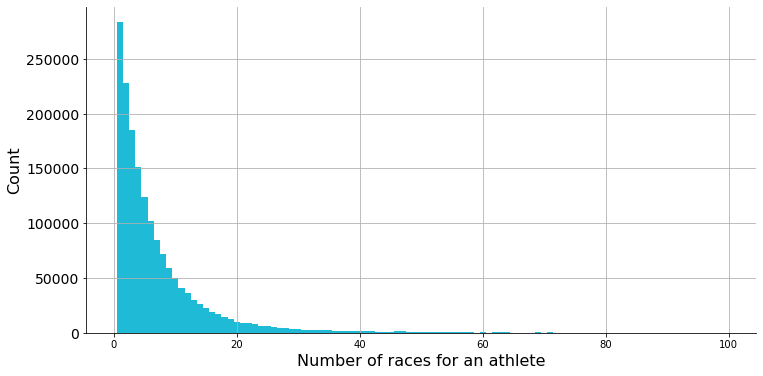

In [34]:
fig,ax = plt.subplots(figsize=(12, 6))

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
ax.set_xlabel('Number of races for an athlete', size=16)
ax.set_ylabel('Count', size=16)

# ax.set_title("Top-N accuracy metrics (1 raced + 100 not raced)", size=20)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

df_results_filtered['n_races'].hist(bins=np.arange(0.5, 100.5, 1), figsize=(12, 6), ax=ax, color='#1FBAD6')
# fig.savefig('figs/athlete-count-races.pdf')
# df_results_filtered.head(5)

A majority of athletes have < 20 races

## We need to make a `profile` for each athlete. What features could we extract from the data we have?

## Years in sport

In [35]:
years_in_sport = (df_results_filtered
     .groupby('athlete')
     .pipe(lambda g: ((g.date.max()-g.date.min()).astype('timedelta64[Y]'))+1) # add 1 so if only one race will be 1 year
     .rename('n_years_in_sport') 
)

athletes_df = athletes_df.merge(years_in_sport.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport
0,,16,4
1,,5,5
2,Avila,1,1
3,Fletcher,2,2
4,Grandjean,1,1


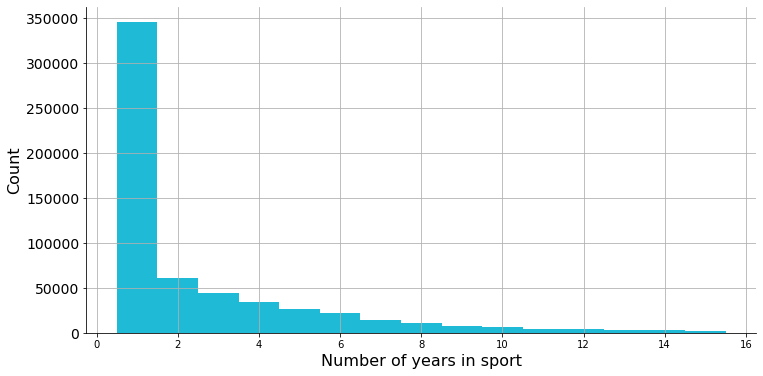

In [36]:
fig,ax = plt.subplots(figsize=(12, 6))

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
ax.set_xlabel('Number of years in sport', size=16)
ax.set_ylabel('Count', size=16)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

athletes_df['n_years_in_sport'].hist(bins=np.arange(0.5, 16.5, 1), figsize=(12, 6), ax=ax, color='#1FBAD6')
# fig.savefig('figs/athlete-years-in-sport.pdf')

## Active years in sport

In [37]:
active_years = (
    df_results_filtered
        .groupby(['athlete', 'year'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("n_active_years_in_sport")
)

athletes_df = athletes_df.merge(active_years.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport
0,,16,4,5
1,,5,5,4
2,Avila,1,1,1
3,Fletcher,2,2,2
4,Grandjean,1,1,1


## Avg number of race per active year

In [38]:
athletes_df['avg_n_races_year'] = athletes_df['n_races']/athletes_df['n_active_years_in_sport']
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year
0,,16,4,5,3.20
1,,5,5,4,1.25
2,Avila,1,1,1,1.00
3,Fletcher,2,2,2,1.00
4,Grandjean,1,1,1,1.00


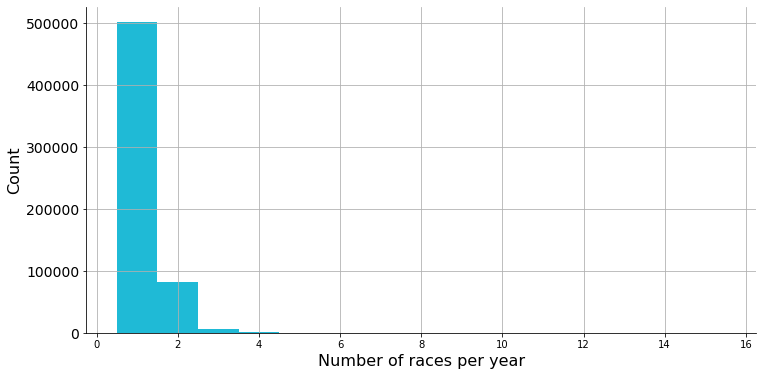

In [39]:
fig,ax = plt.subplots(figsize=(12, 6))

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
ax.set_xlabel('Number of races per year', size=16)
ax.set_ylabel('Count', size=16)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

athletes_df['avg_n_races_year'].hist(bins=np.arange(0.5, 16.5, 1), figsize=(12, 6), ax=ax, color='#1FBAD6')
# fig.savefig('figs/athlete-avg-races-per-years.pdf')

## Unique races

In [40]:
unique_races = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("n_unique_races")
)

athletes_df = athletes_df.merge(unique_races.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races
0,,16,4,5,3.20,5
1,,5,5,4,1.25,3
2,Avila,1,1,1,1.00,1
3,Fletcher,2,2,2,1.00,1
4,Grandjean,1,1,1,1.00,1


In [41]:
athletes_df['perc_unique_races'] = athletes_df['n_unique_races']/athletes_df['n_races']
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races
0,,16,4,5,3.20,5,0.3125
1,,5,5,4,1.25,3,0.6000
2,Avila,1,1,1,1.00,1,1.0000
3,Fletcher,2,2,2,1.00,1,0.5000
4,Grandjean,1,1,1,1.00,1,1.0000


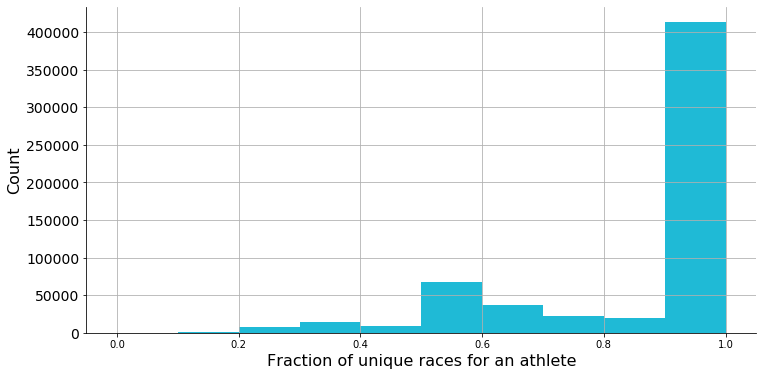

In [42]:
fig,ax = plt.subplots(figsize=(12, 6))

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
ax.set_xlabel('Fraction of unique races for an athlete', size=16)
ax.set_ylabel('Count', size=16)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

athletes_df['perc_unique_races'].hist(bins=np.arange(0., 1.1, 0.1), figsize=(12, 6), ax=ax, color='#1FBAD6')
# fig.savefig('figs/athlete-perc-unique-races.pdf')

# Internationality of the racer?

## Are the races raced in the same region/country?

In [45]:
len(df_races), len(df_results.race.unique())

(157, 157)

In [47]:
# hash for races (region/country)
region_hash = {
    race: region for race,region in df_races.reset_index()[['race', 'region']].values
}
country_hash = {
    race: region for race,region in df_races.reset_index()[['race', 'country_code']].values
}


internationality = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
)

internationality['region'] = internationality.loc[:, 'race'].apply(lambda x: region_hash[x])
internationality['country'] = internationality.loc[:, 'race'].apply(lambda x: country_hash[x])

internationality_region = (
    internationality
        .groupby(['athlete', 'region'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("n_regions_raced")
)

internationality_country = (
    internationality
        .groupby(['athlete', 'country'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("n_countries_raced")
)



athletes_df = athletes_df.merge(internationality_region.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df = athletes_df.merge(internationality_country.astype(int), left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced
0,,16,4,5,3.20,5,0.3125,3,5
1,,5,5,4,1.25,3,0.6000,3,3
2,Avila,1,1,1,1.00,1,1.0000,1,1
3,Fletcher,2,2,2,1.00,1,0.5000,1,1
4,Grandjean,1,1,1,1.00,1,1.0000,1,1


In [48]:
# What's the percentage of races done in different regions?
athletes_df["perc_races_in_diff_regions"] = athletes_df["n_regions_raced"]/athletes_df["n_unique_races"]
# What's the percentage of races done in different countries?
athletes_df["perc_races_in_diff_countries"] = athletes_df["n_countries_raced"]/athletes_df["n_unique_races"]

athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries
0,,16,4,5,3.20,5,0.3125,3,5,0.6,1.0
1,,5,5,4,1.25,3,0.6000,3,3,1.0,1.0
2,Avila,1,1,1,1.00,1,1.0000,1,1,1.0,1.0
3,Fletcher,2,2,2,1.00,1,0.5000,1,1,1.0,1.0
4,Grandjean,1,1,1,1.00,1,1.0000,1,1,1.0,1.0


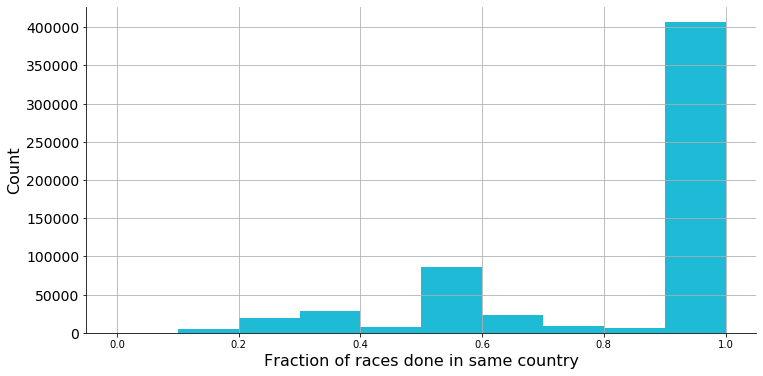

In [49]:
fig,ax = plt.subplots(figsize=(12, 6))

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
ax.set_xlabel('Fraction of races done in same country', size=16)
ax.set_ylabel('Count', size=16)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

athletes_df['perc_races_in_diff_countries'].hist(bins=np.arange(0., 1.1, 0.1), figsize=(12, 6), ax=ax, color='#1FBAD6')
# fig.savefig('figs/athlete-perc-races-in-diff-countries.pdf')

## Percentage of race done in the home country?

In [50]:
df_results_filtered['race_country'] = df_results_filtered.loc[:, 'race'].apply(lambda x: country_hash[x])
df_results_filtered['same_country'] = df_results_filtered['country'] == df_results_filtered['race_country']
df_results_filtered[['country', 'race_country', 'same_country']].head()

,country,race_country,same_country
0,USA,CHN,False
1,AUS,CHN,False
2,JPN,CHN,False
3,AUS,CHN,False
4,JPN,CHN,False


In [51]:
home_races = (
    df_results_filtered
        .groupby(['athlete', 'race'])['same_country']
        .sum()
        .reset_index()
        .groupby('athlete')
        .sum()
        .reset_index()
        .rename(columns={'same_country': 'n_races_in_home_country'})
)

athletes_df = athletes_df.merge(home_races, left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries,n_races_in_home_country
0,,16,4,5,3.20,5,0.3125,3,5,0.6,1.0,0.0
1,,5,5,4,1.25,3,0.6000,3,3,1.0,1.0,1.0
2,Avila,1,1,1,1.00,1,1.0000,1,1,1.0,1.0,0.0
3,Fletcher,2,2,2,1.00,1,0.5000,1,1,1.0,1.0,2.0
4,Grandjean,1,1,1,1.00,1,1.0000,1,1,1.0,1.0,0.0


## Gender

In [52]:
df_results_filtered['gender'] = None
df_results_filtered.loc[df_results_filtered['division'].str.contains("M"), 'gender'] = "M"
df_results_filtered.loc[df_results_filtered['division'].str.contains("F"), 'gender'] = "F"
df_results_filtered.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,date,fulldata,score,swim_score,run_score,bike_score,gender,n_races,race_country,same_country
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,2016-11-13,0,98.4,100.0,86.1,100.0,M,12,CHN,False
1,1518208,Josh Amberger,MPRO,1,1,1,1569,209,7416,142,...,2016-11-13,0,99.7,100.0,97.7,100.0,M,34,CHN,False
2,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,2016-11-13,0,97.1,77.2,100.0,90.7,M,12,CHN,False
3,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,2016-11-13,0,99.9,100.0,100.0,99.7,M,25,CHN,False
4,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,2016-11-13,0,100.0,100.0,100.0,100.0,M,15,CHN,False


In [53]:
gender = (df_results_filtered
     .groupby(['athlete', 'gender'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='gender', values='n')
     .idxmax(axis=1)
     .rename('gender')
)

athletes_df = athletes_df.merge(gender, left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries,n_races_in_home_country,gender
0,,16,4,5,3.20,5,0.3125,3,5,0.6,1.0,0.0,M
1,,5,5,4,1.25,3,0.6000,3,3,1.0,1.0,1.0,M
2,Avila,1,1,1,1.00,1,1.0000,1,1,1.0,1.0,0.0,M
3,Fletcher,2,2,2,1.00,1,0.5000,1,1,1.0,1.0,2.0,F
4,Grandjean,1,1,1,1.00,1,1.0000,1,1,1.0,1.0,0.0,M


## Age Groups
This one is tricky, there could be several age groups is athlete long enough in the sport ... will have to average

In [54]:
df_results_filtered['ag'] = df_results_filtered.division.apply(
    lambda x: list(map(int, re.match("[M|F](\d+)-(\d+)", x).groups()))
    if re.match("[M|F](\d+)-(\d+)", x) 
    else [np.nan, np.nan]
)
df_results_filtered['ag_min'] = df_results_filtered.ag.apply(lambda x: x[0])
df_results_filtered['ag_max'] = df_results_filtered.ag.apply(lambda x: x[1])
df_results_filtered.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,swim_score,run_score,bike_score,gender,n_races,race_country,same_country,ag,ag_min,ag_max
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,100.0,86.1,100.0,M,12,CHN,False,"[75, 79]",75.0,79.0
1,1518208,Josh Amberger,MPRO,1,1,1,1569,209,7416,142,...,100.0,97.7,100.0,M,34,CHN,False,"[nan, nan]",NaN,NaN
2,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,77.2,100.0,90.7,M,12,CHN,False,"[75, 79]",75.0,79.0
3,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,100.0,100.0,99.7,M,25,CHN,False,"[65, 69]",65.0,69.0
4,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,100.0,100.0,100.0,M,15,CHN,False,"[80, 84]",80.0,84.0


In [55]:
age_groups = (
    df_results_filtered
        .groupby(["athlete", "division"])
        .size()
        .reset_index()
        .groupby(['athlete'])
        .size()
        .reset_index()
        .rename(columns={0: "n_ag"})
)
age_groups.sort_values("n_ag", ascending=False).head()

,athlete,n_ag
0,,11
393932,Michael Jones,11
391582,Michael Burke,11
397164,Michael Stone,11
395242,Michael Miller,11


In [56]:
df_results_filtered.loc[df_results_filtered.athlete=="Michael Miller", ["ag_min", "ag_max"]].mean()

ag_min    43.857143
ag_max    47.928571
dtype: float64

In [57]:
age = (df_results_filtered
     .groupby(['athlete'])
     .mean()[['ag_min', 'ag_max']]
     .mean(axis=1)
     .reset_index()
     .rename(columns = {0: "age"})
)

athletes_df = athletes_df.merge(age, left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries,n_races_in_home_country,gender,age
0,,16,4,5,3.20,5,0.3125,3,5,0.6,1.0,0.0,M,46.375
1,,5,5,4,1.25,3,0.6000,3,3,1.0,1.0,1.0,M,56.000
2,Avila,1,1,1,1.00,1,1.0000,1,1,1.0,1.0,0.0,M,52.000
3,Fletcher,2,2,2,1.00,1,0.5000,1,1,1.0,1.0,2.0,F,49.500
4,Grandjean,1,1,1,1.00,1,1.0000,1,1,1.0,1.0,0.0,M,37.000


## Rank

In [58]:
df_results_filtered.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,swim_score,run_score,bike_score,gender,n_races,race_country,same_country,ag,ag_min,ag_max
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,100.0,86.1,100.0,M,12,CHN,False,"[75, 79]",75.0,79.0
1,1518208,Josh Amberger,MPRO,1,1,1,1569,209,7416,142,...,100.0,97.7,100.0,M,34,CHN,False,"[nan, nan]",NaN,NaN
2,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,77.2,100.0,90.7,M,12,CHN,False,"[75, 79]",75.0,79.0
3,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,100.0,100.0,99.7,M,25,CHN,False,"[65, 69]",65.0,69.0
4,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,100.0,100.0,100.0,M,15,CHN,False,"[80, 84]",80.0,84.0


In [59]:
rank = (df_results_filtered
     .groupby(['race', 'year'])
     .apply(lambda g: g['rankoverall']/g.rankoverall.max())
     .reset_index()
).merge(df_results_filtered
     .groupby(['race', 'year'])
     .apply(lambda g: g['athlete'])
     .reset_index()
)
rank.head()

,race,year,level_2,rankoverall,athlete
0,Arizona70.3,2015,205420,0.002727,Trevor Barron
1,Arizona70.3,2015,205425,0.060909,Daniel Murphy
2,Arizona70.3,2015,205429,0.102727,Andre Abreu
3,Arizona70.3,2015,205433,0.103636,Matthew Boufford
4,Arizona70.3,2015,205437,0.210909,Nick Falcon


In [60]:
selection = ["athlete", "swim_score", "bike_score", "run_score"]

activity_scores = (
    # keep only those who finished the race
    df_results_filtered.loc[(df_results_filtered.loc[:, selection][selection[1:]]>0).sum(axis=1) == 3, selection]
        .groupby('athlete')
        .mean()
        .reset_index()
)

athletes_df = athletes_df.merge(activity_scores, left_on="athlete", right_on="athlete", how="left")
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries,n_races_in_home_country,gender,age,swim_score,bike_score,run_score
0,,16,4,5,3.20,5,0.3125,3,5,0.6,1.0,0.0,M,46.375,77.188889,84.600,76.500
1,,5,5,4,1.25,3,0.6000,3,3,1.0,1.0,1.0,M,56.000,79.150000,94.675,94.875
2,Avila,1,1,1,1.00,1,1.0000,1,1,1.0,1.0,0.0,M,52.000,89.600000,90.600,97.800
3,Fletcher,2,2,2,1.00,1,0.5000,1,1,1.0,1.0,2.0,F,49.500,81.500000,87.700,79.200
4,Grandjean,1,1,1,1.00,1,1.0000,1,1,1.0,1.0,0.0,M,37.000,92.400000,97.800,99.700


# SAVE FILE

In [62]:
athletes_df.head()

,athlete,n_races,n_years_in_sport,n_active_years_in_sport,avg_n_races_year,n_unique_races,perc_unique_races,n_regions_raced,n_countries_raced,perc_races_in_diff_regions,perc_races_in_diff_countries,n_races_in_home_country,gender,age,swim_score,bike_score,run_score
0,,16,4,5,3.20,5,0.3125,3,5,0.6,1.0,0.0,M,46.375,77.188889,84.600,76.500
1,,5,5,4,1.25,3,0.6000,3,3,1.0,1.0,1.0,M,56.000,79.150000,94.675,94.875
2,Avila,1,1,1,1.00,1,1.0000,1,1,1.0,1.0,0.0,M,52.000,89.600000,90.600,97.800
3,Fletcher,2,2,2,1.00,1,0.5000,1,1,1.0,1.0,2.0,F,49.500,81.500000,87.700,79.200
4,Grandjean,1,1,1,1.00,1,1.0000,1,1,1.0,1.0,0.0,M,37.000,92.400000,97.800,99.700


In [61]:
len(athletes_df)

591578

# UMAP

In [129]:
min_unique_race_count = 5

# total number of races per athlete
athletes_count_races = (df_results.groupby('athlete')['division']
     .size()
     .reset_index()
     .rename(columns={'division': 'n_races'})
)

# total number of different races per athlete
athletes_count_diff_races = (df_results
     .groupby(['athlete', 'race'])
     .size()
     .reset_index()
     .groupby('athlete')
     .size()
     .reset_index()
     .rename(columns={0: 'n_different_races'})
)

# merge the two so we can filter from that
athlete_habits = athletes_count_diff_races.merge(athletes_count_races, left_on="athlete", right_on="athlete", how="left")

# What we are filtering with
max_count_races = 100 # probably similar names

valid_athletes = athlete_habits.loc[(athlete_habits['n_different_races']>=min_unique_race_count) & (athlete_habits['n_races']<=max_count_races)]

# use this df to filter original results data
df_results_filtered = df_results.loc[df_results['athlete'].isin(valid_athletes['athlete'])]
df_results_filtered = df_results_filtered.merge(valid_athletes, left_on="athlete", right_on="athlete", how="left")

# # Anonimize entrants
# user_hash = {}

# for i,user in enumerate(df_results_filtered.athlete.unique()):
#     user_hash[user] = f'u{i}'
# df_results_filtered.loc[:, 'athlete'] = df_results_filtered.athlete.map(lambda x: user_hash[x])

print("Number of valid individuals:", len(valid_athletes))
print("Number of remaining single results:", len(df_results_filtered))
print("Number of races present in filtered results:", len(df_results_filtered.race.unique()))

Number of valid individuals: 52297
Number of remaining single results: 555730
Number of races present in filtered results: 157


In [130]:
results_races_count = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
        .rename(columns={0: 'count'})
)

# Add demographics info for users (if we want to filter later)
gender = (df_results_filtered
     .groupby(['athlete', 'gender'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='gender', values='n')
     .idxmax(axis=1)
     .rename('gender')
)

country = (df_results_filtered
     .groupby(['athlete', 'country'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='country', values='n')
     .idxmax(axis=1)
     .rename('country')
)

results_races_count = results_races_count.merge(gender, left_on = 'athlete', right_on = 'athlete', how = 'left')
results_races_count = results_races_count.merge(country, left_on = 'athlete', right_on = 'athlete', how = 'left')

results_races_count.head()

,athlete,race,count,gender,country
0,,barcelona,3,M,JPN
1,,cairns,7,M,JPN
2,,canada,1,M,JPN
3,,france,1,M,JPN
4,,newzealand,4,M,JPN


In [131]:
data = results_races_count.pivot(index='race', columns='athlete', values='count').fillna(0)
data.head()

athlete,,*ricardo Grossman,?? ??,A Mattson Davis,A. Trey Traviesa,A.J. Johnson,A.J. Lucina,A.J. Reid,ANDREA TRIBULATO,ANTHONY ROSS,...,Özgür Aksaman,Özkan Dizar,Геращенко Валерий,Турсынбек Тасжанов,丰春 李,刘 晓安,子龙 张,琦 党,观 杜,黄 葳
race,,,,,,,,,,,,,,,,,,,,,
Arizona70.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CostaNavarino70.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DunLaoghaire70.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Florianopolis70.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Haugesund70.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# df_races.loc[:, ['region', 'country_code', 'perc_entrants_from_country', 'perc_entrants_from_region']]

In [80]:
#df_races.loc[:, ['region', 'country_code']]

In [86]:
data_in = data.values

In [132]:
from sklearn.decomposition import PCA

# run PCA
pca = PCA(n_components=10)
pca.fit(data_in)
out = pca.transform(data_in)

In [133]:
color_region_hash = {region: i for i,region in enumerate(df_races['region'].unique())}
color_country_hash = {country: i for i,country in enumerate(df_races['country_code'].unique())}

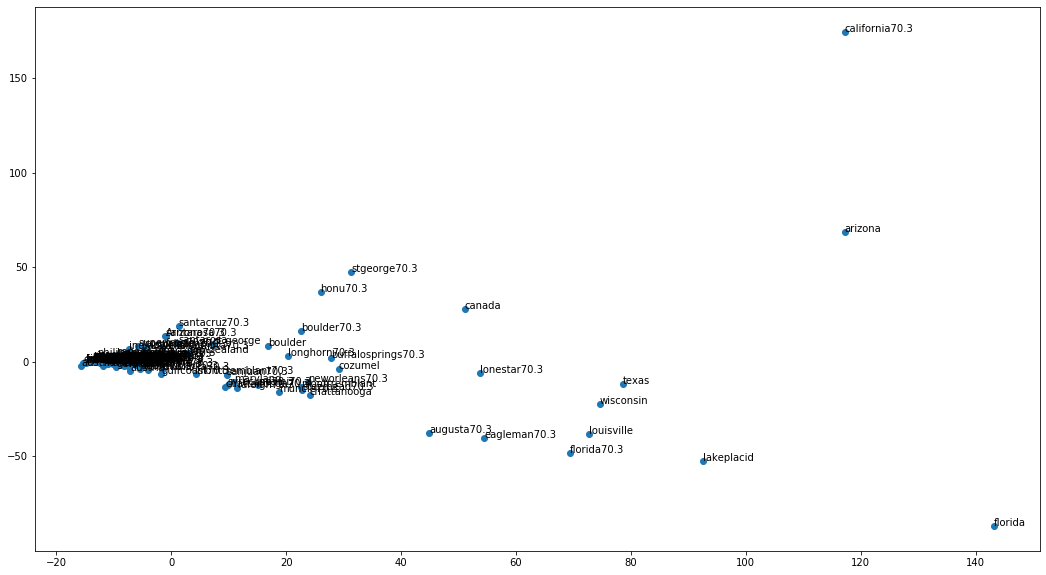

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(18, 10))

ax.scatter(out[:, 0], out[:, 1])

for i, race in enumerate(data.index):
    ax.annotate(race, (out[i, 0], out[i, 1]))

# Global Model

/miniconda3/envs/data-science/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


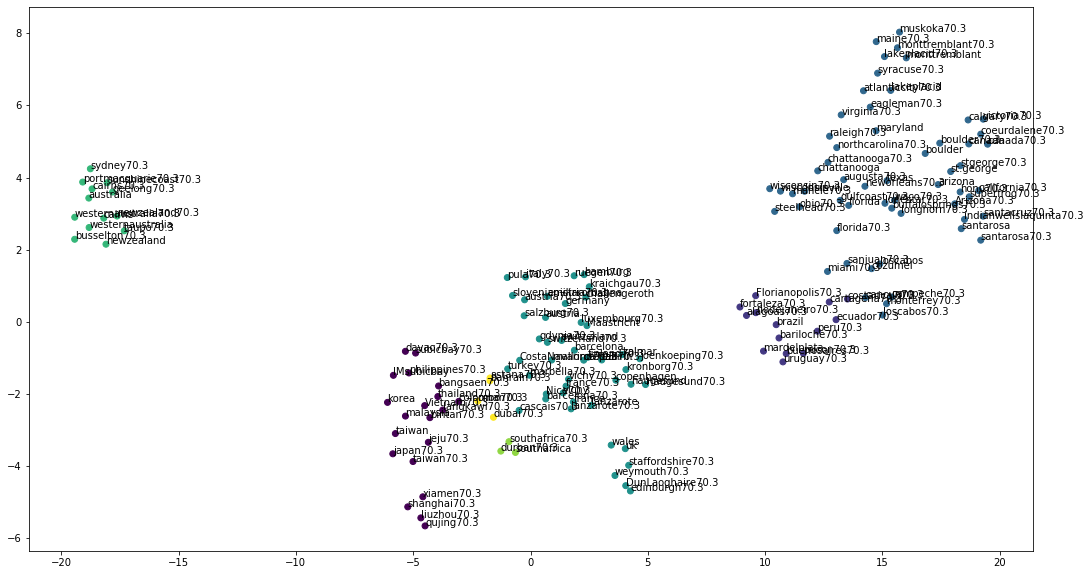

In [135]:
import umap

# run UMAP
umap_model = umap.UMAP(n_neighbors=5,
                       min_dist=0.9,
                       metric='cosine')
umap_embedding = umap_model.fit_transform(data_in)


fig,ax = plt.subplots(figsize=(18, 10))

ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=[color_region_hash[df_races.loc[race, 'region']] for race in data.index])
    
for i, race in enumerate(data.index):
    ax.annotate(race, (umap_embedding[i, 0], umap_embedding[i, 1]))

### UMAP after matrix factorization

In [136]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
svd.fit(data_in)
data_svd = svd.transform(data_in)

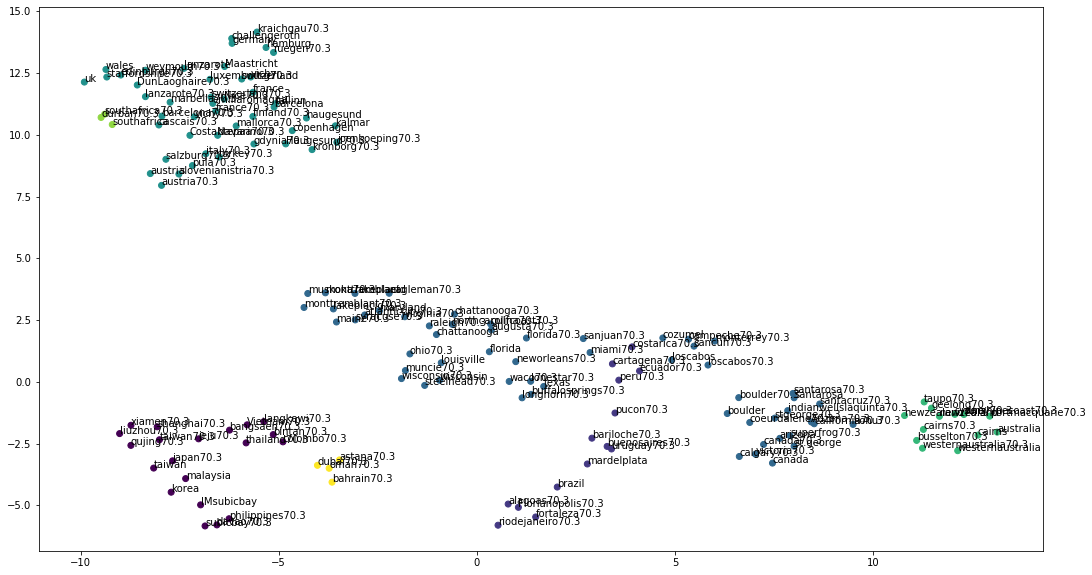

In [137]:
# run UMAP
umap_model = umap.UMAP(n_neighbors=5,
                       min_dist=0.9,
                       metric='cosine')
umap_embedding = umap_model.fit_transform(data_svd)


fig,ax = plt.subplots(figsize=(18, 10))

ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=[color_region_hash[df_races.loc[race, 'region']] for race in data.index])
    
for i, race in enumerate(data.index):
    ax.annotate(race, (umap_embedding[i, 0], umap_embedding[i, 1]))

## Selection of groups

In [138]:
# df_results.head()

In [169]:
group1 = athletes_df.loc[athletes_df['perc_races_in_diff_regions'] >= 0.5, 'athlete'].values
group2 = athletes_df.loc[athletes_df['perc_races_in_diff_regions'] < 0.5, 'athlete'].values

len(group1), len(group2)

(476200, 115378)

/miniconda3/envs/data-science/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


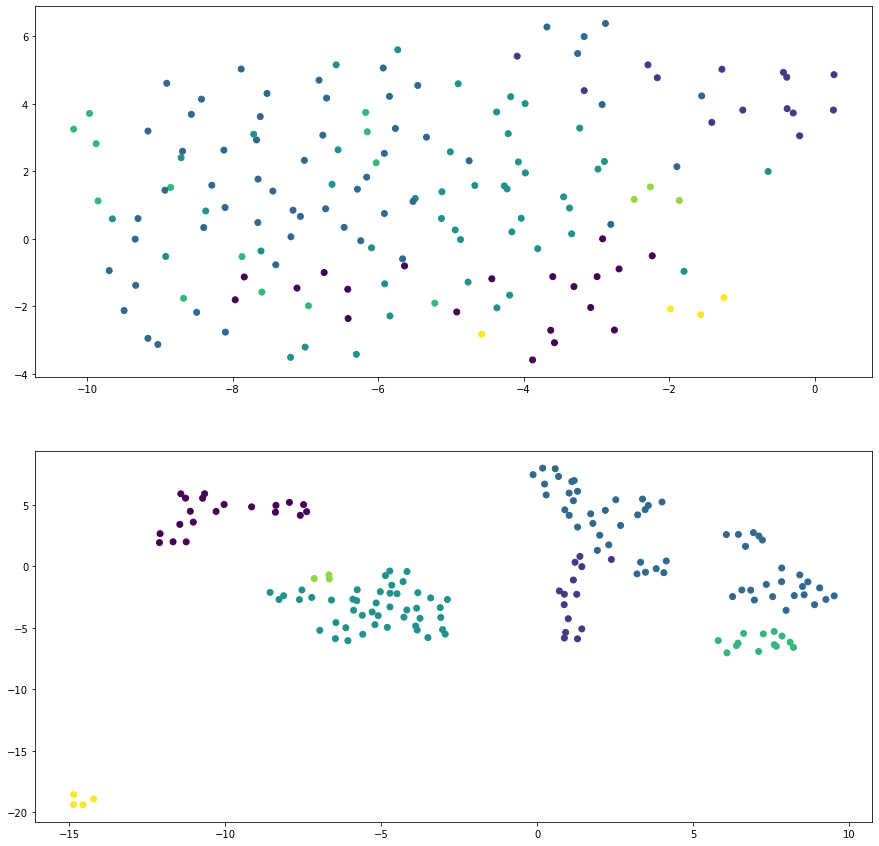

In [170]:
data_group1 = (
    results_races_count
        .loc[results_races_count.athlete.isin(group1)]
        .pivot(index='race', columns='athlete', values='count')
        .fillna(0)
)

data_group2 = (
    results_races_count
        .loc[results_races_count.athlete.isin(group2)]
        .pivot(index='race', columns='athlete', values='count')
        .fillna(0)
)

fig,axes = plt.subplots(nrows=2, figsize=(15, 15))

for i,d in enumerate([data_group1, data_group2]):
    svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
    svd.fit(d.values)
    data_svd = svd.transform(d.values)
    
    # run UMAP
    umap_model = umap.UMAP(n_neighbors=5,
                           min_dist=0.9,
                           metric='cosine')
    umap_embedding = umap_model.fit_transform(data_svd)

    axes[i].scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=[color_region_hash[df_races.loc[race, 'region']] for race in data.index])

#     for j, race in enumerate(data.index):
#         axes[i].annotate(race, (umap_embedding[j, 0], umap_embedding[j, 1]))

In [171]:
import scipy.sparse as sparse

sparse_item_user_group1 = sparse.csr_matrix(data_group1.values)
sparse_item_user_group2 = sparse.csr_matrix(data_group2.values)

print("Matrix size:", sparse_item_user_group1.shape, sparse_item_user_group2.shape)

Matrix size: (157, 3602) (157, 48695)


In [172]:
# use local implicit library (has been compiled using latest github code)
from implicit_local.evaluation import train_test_split, mean_average_precision_at_k, ndcg_at_k
from implicit_local.als import AlternatingLeastSquares

train_group1, test_group1 = train_test_split(sparse_item_user_group1, train_percentage=0.8)
train_group2, test_group2 = train_test_split(sparse_item_user_group2, train_percentage=0.8)

train_conf_group1 = (train_group1 * 5.5).astype('double')
train_conf_group2 = (train_group2 * 5.5).astype('double')

In [173]:
model_group1 = AlternatingLeastSquares(factors=18, regularization=0.01, iterations=50)
model_group1.fit(train_conf_group1, show_progress=False)

model_group2 = AlternatingLeastSquares(factors=18, regularization=0.01, iterations=50)
model_group2.fit(train_conf_group2, show_progress=False)

In [174]:
ndcg_at_k(model_group1, train_group1.T.tocsr(), test_group1.T.tocsr(), K=10, num_threads=4, show_progress=False)

0.2481406006661592

In [175]:
ndcg_at_k(model_group2, train_group2.T.tocsr(), test_group2.T.tocsr(), K=10, num_threads=4, show_progress=False)

0.36952297995693756

In [179]:
import random

def make_train(ratings, perc_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    perc_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of item,user index into list

    
    random.seed(0) # Set the random seed to zero for reproducibility
    
    num_samples = int(np.ceil(perc_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of item-user pairs without replacement

    item_inds = [index[0] for index in samples] # Get the item row indices

    user_inds = [index[1] for index in samples] # Get the user column indices

    
    training_set[item_inds, user_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user columns that were altered

In [180]:
# prepare dataset
full_set = sparse.csr_matrix(data_in)

# split train/test
train, test, users_modified_idx = make_train(full_set, perc_test = 0.2)
print(f'{len(users_modified_idx)} have results that have been altered')

train_conf = (train * 5.5).astype('double')

model = AlternatingLeastSquares(factors=18, regularization=0.01, iterations=50)
model.fit(train, show_progress=False)

40093 have results that have been altered


In [197]:
users_vec_group1 = model_group1.user_factors
items_vec_group1 = model_group1.item_factors

users_vec_group2 = model_group2.user_factors
items_vec_group2 = model_group2.item_factors

# make prediction matrix
all_predictions_group1 = items_vec_group1.dot(users_vec_group1.T)
all_predictions_group2 = items_vec_group2.dot(users_vec_group2.T)

all_predictions_group1.shape, all_predictions_group2.shape

((157, 3602), (157, 48695))

<157x3602 sparse matrix of type '<class 'numpy.float64'>'
	with 4253 stored elements in Compressed Sparse Column format>

In [210]:
def binarize(arr, tol):
    """
    Convert continous valued array to binary. 
    """
    arr[arr < tol] = 0
    arr[arr >= tol] = 1
    return arr

# get the relevant users to use in movel validation
users_true_labels_group1 = sparse.csc_matrix(np.sign(test_group1.toarray()))
users_predictions_group1 = all_predictions_group1#[:, users_modified_idx]
users_true_labels_group2 = sparse.csc_matrix(np.sign(test_group2.toarray()))
users_predictions_group2 = all_predictions_group2#[:, users_modified_idx]

# binarize using the half range for each users
cut_at = 0.5
users_predictions_binarized_group1 = (users_predictions_group1>(users_predictions_group1.max(axis=0)-users_predictions_group1.min(axis=0))*cut_at).astype(int)
users_predictions_binarized_group2 = (users_predictions_group2>(users_predictions_group2.max(axis=0)-users_predictions_group2.min(axis=0))*cut_at).astype(int)

# scale predictions in the [0, 1] interval
users_predictions_scaled_group1 = (users_predictions_group1 - users_predictions_group1.min(axis=0))/(users_predictions_group1.max(axis=0)-users_predictions_group1.min(axis=0))
users_predictions_scaled_group1[np.isnan(users_predictions_scaled_group1)] = 0
users_predictions_scaled_group2 = (users_predictions_group2 - users_predictions_group2.min(axis=0))/(users_predictions_group2.max(axis=0)-users_predictions_group2.min(axis=0))
users_predictions_scaled_group2[np.isnan(users_predictions_scaled_group2)] = 0

/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [211]:
# get indices for users of groups 1 and 2

cols_group1 = np.where(data.columns.isin(group1))[0]
cols_group2 = np.where(data.columns.isin(group2))[0]

In [212]:
from sklearn.metrics import recall_score, precision_score, average_precision_score, f1_score, roc_curve, roc_auc_score

# flatten arrays Group1
y_true_group1 = users_true_labels_group1.toarray().ravel()
y_pred_group1 = users_predictions_binarized_group1.ravel()
y_pred_scaled_group1 = users_predictions_scaled_group1.ravel()

# flatten arrays Group2
y_true_group2 = users_true_labels_group2.toarray().ravel()
y_pred_group2 = users_predictions_binarized_group2.ravel()
y_pred_scaled_group2 = users_predictions_scaled_group2.ravel()


# recall, precision, and f1 are definied for binarized (non-continuous) values 
# of predictions
print('Group 1')
print(f'Recall: {recall_score(y_true_group1, y_pred_group1):.3f}')
print(f'Precision: {precision_score(y_true_group1, y_pred_group1):.3f}')
print(f'Average Precision: {average_precision_score(y_true_group1, y_pred_group1):.3f}')
print(f'F1 score: {f1_score(y_true_group1, y_pred_group1):.3f}')

# roc-auc is more accurate when using continuous predictions.
auc_score_group1 = roc_auc_score(y_true_group1, y_pred_scaled_group1)
print(f'ROC-AUC: {auc_score_group1:.3f}')

# recall, precision, and f1 are definied for binarized (non-continuous) values 
# of predictions
print('Group 2')
print(f'Recall: {recall_score(y_true_group2, y_pred_group2):.3f}')
print(f'Precision: {precision_score(y_true_group2, y_pred_group2):.3f}')
print(f'Average Precision: {average_precision_score(y_true_group2, y_pred_group2):.3f}')
print(f'F1 score: {f1_score(y_true_group2, y_pred_group2):.3f}')

# roc-auc is more accurate when using continuous predictions.
auc_score_group2 = roc_auc_score(y_true_group2, y_pred_scaled_group2)
print(f'ROC-AUC: {auc_score_group2:.3f}')

Group 1
Recall: 0.084
Precision: 0.026
Average Precision: 0.009
F1 score: 0.040
ROC-AUC: 0.700
Group 2
Recall: 0.237
Precision: 0.054
Average Precision: 0.020
F1 score: 0.088
ROC-AUC: 0.802


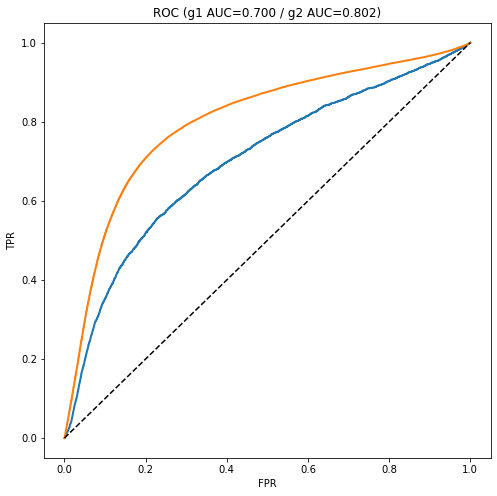

In [214]:
# plot ROC curve
fpr_group1, tpr_group1, thresholds = roc_curve(y_true_group1, y_pred_scaled_group1)
fpr_group2, tpr_group2, thresholds = roc_curve(y_true_group2, y_pred_scaled_group2)

fig,ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr_group1, tpr_group1, lw=2)
ax.plot(fpr_group2, tpr_group2, lw=2)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_title(f'ROC (g1 AUC={auc_score_group1:.3f} / g2 AUC={auc_score_group2:.3f})')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR');